# How to use CNN with time series data

The regular measurements of time series result in a similar grid-like data structure as for the image data we have focused on so far. As a result, we can use CNN architectures for univariate and multivariate time series. In the latter case, we consider different time series as channels, similar to the different color signals.

## Imports & Settings

In [1]:
%matplotlib inline

import sys
from time import time
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from sklearn.feature_selection import mutual_info_regression

import tensorflow as tf
tf.autograph.set_verbosity(0, True)
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, 
                                     Flatten, 
                                     Conv1D, 
                                     MaxPooling1D, 
                                     Dropout, 
                                     BatchNormalization)

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [3]:
sys.path.insert(1, Path(sys.path[0], '..').as_posix())
from utils import MultipleTimeSeriesCV, format_time

In [4]:
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
sns.set_style('whitegrid')

In [6]:
results_path = Path('results', 'time_series')
if not results_path.exists():
    results_path.mkdir(parents=True)

## Prepare Data

In [7]:
prices = (pd.read_hdf('../data/assets.h5', 'quandl/wiki/prices')
          .adj_close
          .unstack().loc['2000':])
prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4706 entries, 2000-01-03 to 2018-03-27
Columns: 3199 entries, A to ZUMZ
dtypes: float64(3199)
memory usage: 114.9 MB


### Compute monthly returns

In [8]:
returns = (prices
           .resample('M')
           .last()
           .pct_change()
           .dropna(how='all')
           .loc['2000': '2017']
           .dropna(axis=1)
           .sort_index(ascending=False))

# remove outliers likely representing data errors
returns = returns.where(returns<1).dropna(axis=1)
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2017-12-31 to 2000-02-29
Freq: -1M
Columns: 1511 entries, A to ZQK
dtypes: float64(1511)
memory usage: 2.5 MB


### Create model data

In [9]:
n = len(returns)
nlags = 12
lags = list(range(1, nlags + 1))

In [10]:
cnn_data = []
for i in range(n-nlags-1):
    df = returns.iloc[i:i+nlags+1]        # select outcome and lags
    date = df.index.max()                 # use outcome date
    cnn_data.append(df.reset_index(drop=True)  # append transposed series
                    .transpose()
                    .assign(date=date)
                    .set_index('date', append=True)
                    .sort_index(1, ascending=True))

cnn_data = (pd.concat(cnn_data)
            .rename(columns={0: 'label'})
            .sort_index())

cnn_data.info(null_counts=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 305222 entries, ('A', Timestamp('2001-03-31 00:00:00')) to ('ZQK', Timestamp('2017-12-31 00:00:00'))
Data columns (total 13 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   label   305222 non-null  float64
 1   1       305222 non-null  float64
 2   2       305222 non-null  float64
 3   3       305222 non-null  float64
 4   4       305222 non-null  float64
 5   5       305222 non-null  float64
 6   6       305222 non-null  float64
 7   7       305222 non-null  float64
 8   8       305222 non-null  float64
 9   9       305222 non-null  float64
 10  10      305222 non-null  float64
 11  11      305222 non-null  float64
 12  12      305222 non-null  float64
dtypes: float64(13)
memory usage: 31.5+ MB


<ipython-input-10-8629bb5ba869>:15: FutureWarning: null_counts is deprecated. Use show_counts instead
  cnn_data.info(null_counts=True)


## Evaluate features

### Mutual Information

In [11]:
# mi = mutual_info_regression(X=cnn_data.drop('label', axis=1), y=cnn_data.label)
# mi = pd.Series(mi, index=cnn_data.drop('label', axis=1).columns)

### Information Coefficient

In [12]:
# ic = {}
# for lag in lags:
#     ic[lag] = spearmanr(cnn_data.label, cnn_data[lag])
# ic = pd.DataFrame(ic, index=['IC', 'p-value']).T

In [13]:
# ax = ic.plot.bar(rot=0, figsize=(14, 4),
#                  ylim=(-0.05, .05),
#                  title='Feature Evaluation')
# ax.set_xlabel('Lag')
# sns.despine()
# plt.tight_layout()
# plt.savefig(results_path / 'cnn_ts1d_feature_ic', dpi=300)

### Plot Metrics

In [14]:
# metrics = pd.concat([mi.to_frame('Mutual Information'),
#                      ic.IC.to_frame('Information Coefficient')], axis=1)

In [15]:
# ax = metrics.plot.bar(figsize=(12, 4), rot=0)
# ax.set_xlabel('Lag')
# sns.despine()
# plt.tight_layout()
# plt.savefig(results_path / 'ts1d_metrics', dpi=300)

## CNN

### Model Architecture

We design a simple one-layer CNN that uses one-dimensional convolutions combined with max pooling to learn time series patterns:

In [16]:
def get_model(filters=32, kernel_size=5, pool_size=2):
    model = Sequential([Conv1D(filters=filters,
                               kernel_size=kernel_size,
                               activation='relu',
                               padding='causal',
                               input_shape=input_shape,
                               use_bias=True,
                               kernel_regularizer=regularizers.l1_l2(l1=1e-5,
                                                                     l2=1e-5)),
                        MaxPooling1D(pool_size=pool_size),
                        Flatten(),
                        BatchNormalization(),
                        Dense(1, activation='linear')])
    model.compile(loss='mse',
                  optimizer='Adam')
    return model

### Set up CV

In [17]:
cv = MultipleTimeSeriesCV(n_splits=12 * 3,
                          train_period_length=12 * 5,
                          test_period_length=1,
                          lookahead=1)

In [18]:
input_shape = nlags, 1

### Train Model

In [19]:
def get_train_valid_data(X, y, train_idx, test_idx):
    x_train, y_train = X.iloc[train_idx, :], y.iloc[train_idx]
    x_val, y_val = X.iloc[test_idx, :], y.iloc[test_idx]
    m = X.shape[1]
    return (x_train.values.reshape(-1, m, 1), y_train,
            x_val.values.reshape(-1, m, 1), y_val)

In [20]:
batch_size = 64
epochs = 100

In [21]:
filters = 32
kernel_size = 4
pool_size = 4

In [22]:
get_model(filters=filters,
          kernel_size=kernel_size, 
          pool_size=pool_size).summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 12, 32)            160       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3, 32)             0         
_________________________________________________________________
flatten (Flatten)            (None, 96)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 96)                384       
_________________________________________________________________
dense (Dense)                (None, 1)                 97        
Total params: 641
Trainable params: 449
Non-trainable params: 192
_________________________________________________________________


### Cross-validation loop

In [23]:
result = {}
start = time()
for fold, (train_idx, test_idx) in enumerate(cv.split(cnn_data)):
    X_train, y_train, X_val, y_val = get_train_valid_data(cnn_data
                                                          .drop('label', axis=1)
                                                          .sort_index(ascending=False),
                                                          cnn_data.label,
                                                          train_idx,
                                                          test_idx)
    test_date = y_val.index.get_level_values('date').max()
    model = get_model(filters=filters,
                      kernel_size=kernel_size,
                      pool_size=pool_size)
    
    best_ic = -np.inf
    stop = 0
    for epoch in range(50):         
        training = model.fit(X_train, y_train,
                             batch_size=batch_size,
                             validation_data=(X_val, y_val),
                             epochs=epoch + 1,
                             initial_epoch=epoch,
                             verbose=0,
                             shuffle=True)
        predicted = model.predict(X_val).squeeze()
        ic, p_val_ = spearmanr(predicted, y_val)
        if ic > best_ic:
            best_ic = ic
            p_val = p_val_
            stop = 0
        else:
            stop += 1
        if stop == 10:
            break
    
    nrounds = epoch + 1 - stop
    result[test_date] = [nrounds, best_ic, p_val]
    df = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T
    msg = f'{fold + 1:02d} | {format_time(time()-start)} | {nrounds:3.0f} | '
    print(msg + f'{best_ic*100:5.2} ({p_val:7.2%}) | {df.IC.mean()*100:5.2}')

01 | 00:00:22 |   3 |   2.5 ( 32.73%) |   2.5
02 | 00:01:10 |  15 |   2.8 ( 27.18%) |   2.7
03 | 00:01:30 |   1 | -0.78 ( 76.06%) |   1.5
04 | 00:01:52 |   1 |  -2.0 ( 43.56%) |  0.64
05 | 00:02:12 |   9 |   2.5 ( 32.85%) |   1.0
06 | 00:02:24 |   1 |   4.8 (  6.08%) |   1.6
07 | 00:02:41 |   3 |   1.6 ( 54.00%) |   1.6
08 | 00:03:15 |  17 |   1.5 ( 56.27%) |   1.6
09 | 00:03:31 |   2 |   2.0 ( 44.74%) |   1.7
10 | 00:03:50 |   4 |   2.8 ( 28.15%) |   1.8
11 | 00:04:04 |   1 |  -1.0 ( 69.06%) |   1.5
12 | 00:04:18 |   1 |   3.9 ( 13.20%) |   1.7
13 | 00:04:37 |   4 |   3.4 ( 18.15%) |   1.8
14 | 00:04:60 |   8 |   4.4 (  8.41%) |   2.0
15 | 00:05:14 |   1 |   3.4 ( 18.66%) |   2.1
16 | 00:05:41 |  15 |   1.9 ( 46.11%) |   2.1
17 | 00:05:52 |   1 |   2.4 ( 36.05%) |   2.1
18 | 00:06:08 |   6 |   2.4 ( 34.88%) |   2.1
19 | 00:06:45 |  18 |   4.0 ( 11.75%) |   2.2
20 | 00:07:28 |  23 |   7.8 (  0.24%) |   2.5
21 | 00:07:42 |   1 |   3.4 ( 18.18%) |   2.6
22 | 00:08:19 |  18 |  0.71 ( 78.3

### Evaluate Results

In [24]:
metrics = pd.DataFrame(result, index=['epochs', 'IC', 'p-value']).T

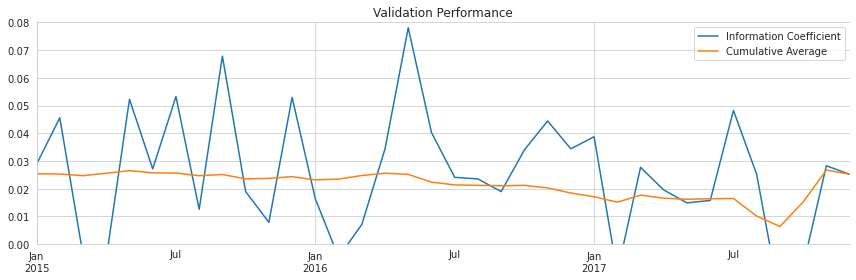

In [25]:
ax = metrics.IC.plot(figsize=(12, 4), 
                     label='Information Coefficient',
                     title='Validation Performance',
                    ylim=(0, .08))
metrics.IC.expanding().mean().plot(ax=ax, label='Cumulative Average')
plt.legend()
sns.despine()
plt.tight_layout()
plt.savefig(results_path / 'cnn_ts1d_ic', dpi=300);